In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import time
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [26]:
IMAGE_SIZE = 32 # 모델 입력 크기
BATCH_SIZE = 64
EPOCHS = 1 # (테스트용 Epoch)
NUM_CLASSES = 10

# GPU/CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


Dataset 구성

Files already downloaded and verified
Files already downloaded and verified
Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10
Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))
10
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


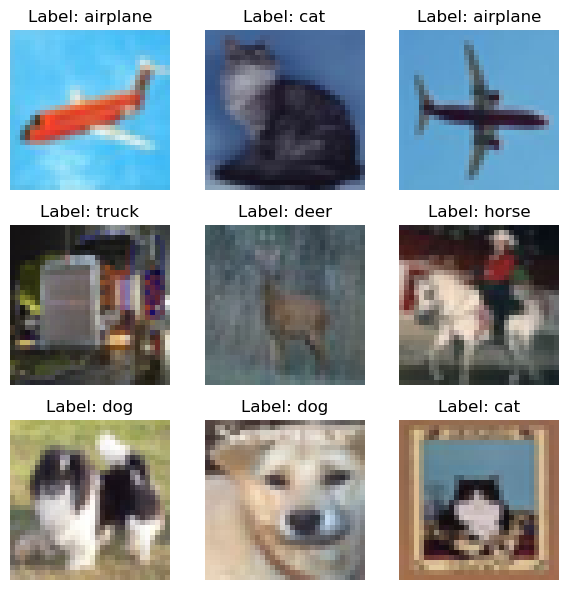

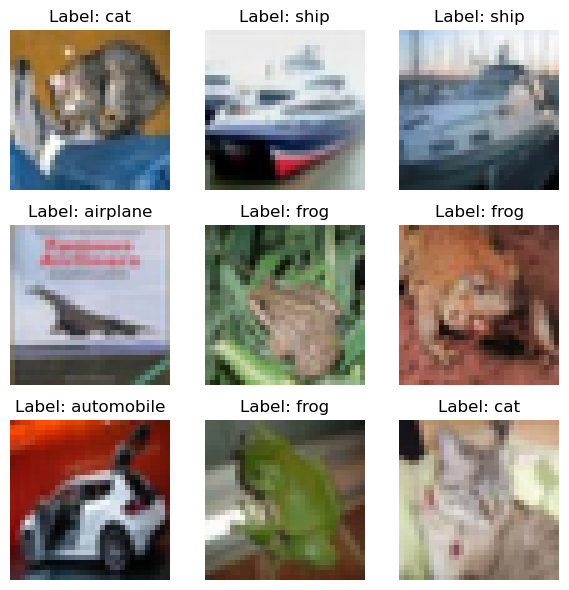

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

# 데이터셋 개수 확인
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")
print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

# Q. 이미지의 표현이 0과 1 사이로 들어오도록 직접 Pytorch 정규화 코드를 작성해봅시다.
transform = transforms.Compose([
    transforms.ToTensor()  # uint8 → float32 변환 + 0~1 정규화
])

num_classes = len(trainset.classes)
print(num_classes)

class_names = trainset.classes
print(class_names)

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

def show_multiple_images(dataset, n_images=9):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    fig, axes = plt.subplots(3, 3, figsize=(6, 6))
    axes = axes.flatten()

    for i in range(n_images):
        ax = axes[i]
        img = imshow(images[i])
        ax.imshow(img)
        ax.set_title(f"Label: {trainset.classes[labels[i]]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# 학습 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(trainloader)

# 테스트 데이터셋에서 9개의 이미지를 시각화합니다.
show_multiple_images(testloader)

모델 구성

In [28]:
class BasicBlock(nn.Module):
    """ResNet-34용 BasicBlock (PyTorch)"""
    expansion = 1 # 이 블록은 채널 수를 변경하지 않음

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # 1. 메인 경로
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 2. 잔차 경로 (Shortcut)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            # 크기나 채널이 다를 경우 1x1 Conv로 맞춤
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        out += self.shortcut(identity) # Add()
        out = self.relu(out)
        
        return out

class BottleneckBlock(nn.Module):
    """ResNet-50용 BottleneckBlock (PyTorch)"""
    expansion = 4 # 이 블록은 채널 수를 4배 확장

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()

        # 1. 메인 경로 (1x1 -> 3x3 -> 1x1)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 2. 잔차 경로 (Shortcut)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out)) # 마지막 Add() 이전에는 ReLU 없음
        
        out += self.shortcut(identity) # Add()
        out = self.relu(out)
        
        return out

In [29]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks_list, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64

        # 1. Stem (TF 코드와 동일하게 3x3 Conv 사용)
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        # 2. 잔차 블록 스테이지
        self.layer1 = self._make_layer(block, 64, num_blocks_list[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks_list[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks_list[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks_list[3], stride=2)

        # 3. Classifier (GlobalAveragePooling2D + Dense)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1) # Flatten
        out = self.fc(out)
        return out

In [30]:
def build_resnet34(num_classes=2):
    # num_blocks_list [3, 4, 6, 3]
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

def build_resnet50(num_classes=2):
    # num_blocks_list [3, 4, 6, 3]
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

PlainNet 만들기

In [31]:
class PlainBlock(nn.Module):
    """PlainNet-34용 블록 (BasicBlock에서 잔차 연결 제거)"""
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.relu(out) # Keras 코드와 동일하게 마지막에 ReLU
        return out

class PlainBottleneckBlock(nn.Module):
    """PlainNet-50용 블록 (BottleneckBlock에서 잔차 연결 제거)"""
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBottleneckBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = self.relu(out) # Keras 코드와 동일하게 마지막에 ReLU
        return out

In [32]:
PlainNet = ResNet

def build_plainnet34(num_classes=2):
    # [3, 4, 6, 3]
    return PlainNet(PlainBlock, [3, 4, 6, 3], num_classes)

def build_plainnet50(num_classes=2):
    # [3, 4, 6, 3]
    return PlainNet(PlainBottleneckBlock, [3, 4, 6, 3], num_classes)

In [33]:
from torchsummary import summary
IMAGE_SIZE = 32
NUM_CLASSES = 2

# ResNet-34 생성
resnet_34 = build_resnet34(num_classes=NUM_CLASSES)
resnet_34.to(device)
summary(resnet_34, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))


resnet_50 = build_resnet50(num_classes=NUM_CLASSES)
resnet_50.to(device)
summary(resnet_50, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))


plainnet_34 = build_plainnet34(num_classes=NUM_CLASSES)
plainnet_34.to(device)
summary(plainnet_34, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))


plainnet_50 = build_plainnet50(num_classes=NUM_CLASSES)
plainnet_50.to(device)
summary(plainnet_50, input_size=(3, IMAGE_SIZE, IMAGE_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,864
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
       BasicBlock-10           [-1, 64, 32, 32]               0
           Conv2d-11           [-1, 64, 32, 32]          36,864
      BatchNorm2d-12           [-1, 64, 32, 32]             128
             ReLU-13           [-1, 64, 32, 32]               0
           Conv2d-14           [-1, 64,

모델 학습

In [34]:
import torch.optim as optim
import time
from tqdm import tqdm, trange

# --------------------------------------------------------------------------
# 1. 하이퍼파라미터 및 설정
# --------------------------------------------------------------------------
# (데이터로더의 BATCH_SIZE=32는 사용자님이 주신 코드를 따름)
EPOCHS = 30       # (테스트용 Epoch)
NUM_CLASSES = 10  # (CIFAR-10은 10개 클래스)

# GPU/CPU 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda



--- Training ResNet-34 for 30 epochs ---


Epoch for ResNet-34:   3%|▎         | 1/30 [00:26<12:49, 26.54s/it]

Epoch [1/30] - Train Loss: 1.4453, Train Acc: 47.10% - Val Loss: 1.1795, Val Acc: 58.31%


Epoch for ResNet-34:   7%|▋         | 2/30 [00:53<12:24, 26.59s/it]

Epoch [2/30] - Train Loss: 0.9332, Train Acc: 67.09% - Val Loss: 0.7856, Val Acc: 72.28%


Epoch for ResNet-34:  10%|█         | 3/30 [01:19<11:56, 26.53s/it]

Epoch [3/30] - Train Loss: 0.6746, Train Acc: 76.67% - Val Loss: 0.6214, Val Acc: 78.67%


Epoch for ResNet-34:  13%|█▎        | 4/30 [01:45<11:27, 26.46s/it]

Epoch [4/30] - Train Loss: 0.5295, Train Acc: 81.77% - Val Loss: 0.5988, Val Acc: 79.26%


Epoch for ResNet-34:  17%|█▋        | 5/30 [02:12<11:01, 26.47s/it]

Epoch [5/30] - Train Loss: 0.4158, Train Acc: 85.59% - Val Loss: 0.4737, Val Acc: 83.86%


Epoch for ResNet-34:  20%|██        | 6/30 [02:38<10:34, 26.42s/it]

Epoch [6/30] - Train Loss: 0.3276, Train Acc: 88.65% - Val Loss: 0.5752, Val Acc: 81.35%


Epoch for ResNet-34:  23%|██▎       | 7/30 [03:05<10:13, 26.67s/it]

Epoch [7/30] - Train Loss: 0.2384, Train Acc: 91.71% - Val Loss: 0.5610, Val Acc: 83.21%


Epoch for ResNet-34:  27%|██▋       | 8/30 [03:32<09:46, 26.66s/it]

Epoch [8/30] - Train Loss: 0.1740, Train Acc: 93.88% - Val Loss: 0.5039, Val Acc: 84.67%


Epoch for ResNet-34:  30%|███       | 9/30 [03:59<09:19, 26.62s/it]

Epoch [9/30] - Train Loss: 0.1267, Train Acc: 95.49% - Val Loss: 0.5885, Val Acc: 83.93%


Epoch for ResNet-34:  33%|███▎      | 10/30 [04:25<08:53, 26.66s/it]

Epoch [10/30] - Train Loss: 0.1004, Train Acc: 96.48% - Val Loss: 0.6056, Val Acc: 84.75%


Epoch for ResNet-34:  37%|███▋      | 11/30 [04:52<08:25, 26.61s/it]

Epoch [11/30] - Train Loss: 0.0827, Train Acc: 97.11% - Val Loss: 0.6019, Val Acc: 84.69%


Epoch for ResNet-34:  40%|████      | 12/30 [05:18<07:54, 26.35s/it]

Epoch [12/30] - Train Loss: 0.0685, Train Acc: 97.68% - Val Loss: 0.5986, Val Acc: 85.80%


Epoch for ResNet-34:  43%|████▎     | 13/30 [05:43<07:25, 26.20s/it]

Epoch [13/30] - Train Loss: 0.0630, Train Acc: 97.82% - Val Loss: 0.6045, Val Acc: 84.99%


Epoch for ResNet-34:  47%|████▋     | 14/30 [06:09<06:56, 26.05s/it]

Epoch [14/30] - Train Loss: 0.0512, Train Acc: 98.22% - Val Loss: 0.6647, Val Acc: 84.90%


Epoch for ResNet-34:  50%|█████     | 15/30 [06:35<06:29, 25.96s/it]

Epoch [15/30] - Train Loss: 0.0489, Train Acc: 98.32% - Val Loss: 0.6594, Val Acc: 85.18%


Epoch for ResNet-34:  53%|█████▎    | 16/30 [07:01<06:03, 25.98s/it]

Epoch [16/30] - Train Loss: 0.0444, Train Acc: 98.50% - Val Loss: 0.6313, Val Acc: 85.88%


Epoch for ResNet-34:  57%|█████▋    | 17/30 [07:27<05:36, 25.89s/it]

Epoch [17/30] - Train Loss: 0.0397, Train Acc: 98.70% - Val Loss: 0.7096, Val Acc: 85.08%


Epoch for ResNet-34:  60%|██████    | 18/30 [07:52<05:10, 25.86s/it]

Epoch [18/30] - Train Loss: 0.0393, Train Acc: 98.66% - Val Loss: 0.6568, Val Acc: 85.41%


Epoch for ResNet-34:  63%|██████▎   | 19/30 [08:18<04:43, 25.80s/it]

Epoch [19/30] - Train Loss: 0.0327, Train Acc: 98.88% - Val Loss: 0.7012, Val Acc: 85.77%


Epoch for ResNet-34:  67%|██████▋   | 20/30 [08:44<04:18, 25.80s/it]

Epoch [20/30] - Train Loss: 0.0316, Train Acc: 98.91% - Val Loss: 0.7585, Val Acc: 84.98%


Epoch for ResNet-34:  70%|███████   | 21/30 [09:11<03:56, 26.27s/it]

Epoch [21/30] - Train Loss: 0.0329, Train Acc: 98.91% - Val Loss: 0.7215, Val Acc: 85.10%


Epoch for ResNet-34:  73%|███████▎  | 22/30 [09:38<03:31, 26.41s/it]

Epoch [22/30] - Train Loss: 0.0281, Train Acc: 99.01% - Val Loss: 0.6631, Val Acc: 86.18%


Epoch for ResNet-34:  77%|███████▋  | 23/30 [10:05<03:05, 26.50s/it]

Epoch [23/30] - Train Loss: 0.0248, Train Acc: 99.15% - Val Loss: 0.7357, Val Acc: 85.77%


Epoch for ResNet-34:  80%|████████  | 24/30 [10:31<02:38, 26.41s/it]

Epoch [24/30] - Train Loss: 0.0295, Train Acc: 99.04% - Val Loss: 0.7654, Val Acc: 85.12%


Epoch for ResNet-34:  83%|████████▎ | 25/30 [10:57<02:11, 26.34s/it]

Epoch [25/30] - Train Loss: 0.0203, Train Acc: 99.31% - Val Loss: 0.7448, Val Acc: 86.16%


Epoch for ResNet-34:  87%|████████▋ | 26/30 [11:23<01:44, 26.24s/it]

Epoch [26/30] - Train Loss: 0.0238, Train Acc: 99.18% - Val Loss: 0.7462, Val Acc: 85.98%


Epoch for ResNet-34:  90%|█████████ | 27/30 [11:49<01:18, 26.14s/it]

Epoch [27/30] - Train Loss: 0.0195, Train Acc: 99.35% - Val Loss: 0.7629, Val Acc: 85.74%


Epoch for ResNet-34:  93%|█████████▎| 28/30 [12:15<00:52, 26.11s/it]

Epoch [28/30] - Train Loss: 0.0220, Train Acc: 99.25% - Val Loss: 0.7528, Val Acc: 85.73%


Epoch for ResNet-34:  97%|█████████▋| 29/30 [12:41<00:26, 26.21s/it]

Epoch [29/30] - Train Loss: 0.0200, Train Acc: 99.33% - Val Loss: 0.7461, Val Acc: 85.56%


Epoch for ResNet-34: 100%|██████████| 30/30 [13:08<00:00, 26.28s/it]


Epoch [30/30] - Train Loss: 0.0225, Train Acc: 99.26% - Val Loss: 0.7398, Val Acc: 85.63%
--- ResNet-34 training finished in 788.44 seconds ---
Model ResNet-34 saved to ResNet-34_cifar10_model.pth

--- Training ResNet-50 for 30 epochs ---


Epoch for ResNet-50:   3%|▎         | 1/30 [00:31<15:04, 31.18s/it]

Epoch [1/30] - Train Loss: 1.4795, Train Acc: 46.37% - Val Loss: 1.8193, Val Acc: 45.31%


Epoch for ResNet-50:   7%|▋         | 2/30 [01:02<14:40, 31.44s/it]

Epoch [2/30] - Train Loss: 0.9641, Train Acc: 65.83% - Val Loss: 0.9878, Val Acc: 65.09%


Epoch for ResNet-50:  10%|█         | 3/30 [01:34<14:10, 31.50s/it]

Epoch [3/30] - Train Loss: 0.7589, Train Acc: 73.40% - Val Loss: 0.7153, Val Acc: 74.87%


Epoch for ResNet-50:  13%|█▎        | 4/30 [02:07<13:59, 32.27s/it]

Epoch [4/30] - Train Loss: 0.6284, Train Acc: 78.07% - Val Loss: 0.6711, Val Acc: 76.51%


Epoch for ResNet-50:  17%|█▋        | 5/30 [02:40<13:33, 32.53s/it]

Epoch [5/30] - Train Loss: 0.5275, Train Acc: 81.70% - Val Loss: 0.6153, Val Acc: 79.38%


Epoch for ResNet-50:  20%|██        | 6/30 [03:14<13:07, 32.80s/it]

Epoch [6/30] - Train Loss: 0.4324, Train Acc: 85.12% - Val Loss: 0.6102, Val Acc: 81.37%


Epoch for ResNet-50:  23%|██▎       | 7/30 [03:47<12:35, 32.85s/it]

Epoch [7/30] - Train Loss: 0.3546, Train Acc: 87.60% - Val Loss: 0.6301, Val Acc: 79.76%


Epoch for ResNet-50:  27%|██▋       | 8/30 [04:18<11:54, 32.47s/it]

Epoch [8/30] - Train Loss: 0.2814, Train Acc: 90.15% - Val Loss: 0.5926, Val Acc: 82.35%


Epoch for ResNet-50:  30%|███       | 9/30 [04:50<11:17, 32.27s/it]

Epoch [9/30] - Train Loss: 0.2265, Train Acc: 92.07% - Val Loss: 0.7650, Val Acc: 80.30%


Epoch for ResNet-50:  33%|███▎      | 10/30 [05:22<10:41, 32.07s/it]

Epoch [10/30] - Train Loss: 0.1735, Train Acc: 94.05% - Val Loss: 0.6710, Val Acc: 81.65%


Epoch for ResNet-50:  37%|███▋      | 11/30 [05:54<10:08, 32.03s/it]

Epoch [11/30] - Train Loss: 0.1431, Train Acc: 94.90% - Val Loss: 0.5996, Val Acc: 83.82%


Epoch for ResNet-50:  40%|████      | 12/30 [06:25<09:33, 31.89s/it]

Epoch [12/30] - Train Loss: 0.1151, Train Acc: 95.91% - Val Loss: 0.6479, Val Acc: 83.78%


Epoch for ResNet-50:  43%|████▎     | 13/30 [06:57<09:01, 31.84s/it]

Epoch [13/30] - Train Loss: 0.1018, Train Acc: 96.35% - Val Loss: 0.6582, Val Acc: 82.60%


Epoch for ResNet-50:  47%|████▋     | 14/30 [07:28<08:27, 31.74s/it]

Epoch [14/30] - Train Loss: 0.0878, Train Acc: 96.92% - Val Loss: 0.7401, Val Acc: 83.32%


Epoch for ResNet-50:  50%|█████     | 15/30 [08:02<08:03, 32.21s/it]

Epoch [15/30] - Train Loss: 0.0788, Train Acc: 97.22% - Val Loss: 0.7036, Val Acc: 83.79%


Epoch for ResNet-50:  53%|█████▎    | 16/30 [08:35<07:36, 32.59s/it]

Epoch [16/30] - Train Loss: 0.0738, Train Acc: 97.41% - Val Loss: 0.7539, Val Acc: 83.80%


Epoch for ResNet-50:  57%|█████▋    | 17/30 [09:09<07:07, 32.88s/it]

Epoch [17/30] - Train Loss: 0.0690, Train Acc: 97.64% - Val Loss: 0.7626, Val Acc: 83.23%


Epoch for ResNet-50:  60%|██████    | 18/30 [09:41<06:31, 32.63s/it]

Epoch [18/30] - Train Loss: 0.0610, Train Acc: 97.84% - Val Loss: 0.8280, Val Acc: 82.89%


Epoch for ResNet-50:  63%|██████▎   | 19/30 [10:13<05:55, 32.35s/it]

Epoch [19/30] - Train Loss: 0.0554, Train Acc: 98.03% - Val Loss: 0.7352, Val Acc: 83.75%


Epoch for ResNet-50:  67%|██████▋   | 20/30 [10:44<05:21, 32.18s/it]

Epoch [20/30] - Train Loss: 0.0515, Train Acc: 98.23% - Val Loss: 0.8789, Val Acc: 82.98%


Epoch for ResNet-50:  70%|███████   | 21/30 [11:16<04:47, 32.00s/it]

Epoch [21/30] - Train Loss: 0.0508, Train Acc: 98.28% - Val Loss: 0.7772, Val Acc: 83.77%


Epoch for ResNet-50:  73%|███████▎  | 22/30 [11:48<04:15, 31.91s/it]

Epoch [22/30] - Train Loss: 0.0452, Train Acc: 98.44% - Val Loss: 0.8683, Val Acc: 83.91%


Epoch for ResNet-50:  77%|███████▋  | 23/30 [12:19<03:42, 31.86s/it]

Epoch [23/30] - Train Loss: 0.0444, Train Acc: 98.52% - Val Loss: 0.8631, Val Acc: 83.11%


Epoch for ResNet-50:  80%|████████  | 24/30 [12:51<03:11, 31.84s/it]

Epoch [24/30] - Train Loss: 0.0417, Train Acc: 98.66% - Val Loss: 0.7601, Val Acc: 84.50%


Epoch for ResNet-50:  83%|████████▎ | 25/30 [13:23<02:38, 31.77s/it]

Epoch [25/30] - Train Loss: 0.0391, Train Acc: 98.68% - Val Loss: 0.8218, Val Acc: 84.44%


Epoch for ResNet-50:  87%|████████▋ | 26/30 [13:55<02:07, 31.97s/it]

Epoch [26/30] - Train Loss: 0.0367, Train Acc: 98.67% - Val Loss: 0.8626, Val Acc: 83.38%


Epoch for ResNet-50:  90%|█████████ | 27/30 [14:29<01:37, 32.44s/it]

Epoch [27/30] - Train Loss: 0.0351, Train Acc: 98.83% - Val Loss: 0.8582, Val Acc: 83.98%


Epoch for ResNet-50:  93%|█████████▎| 28/30 [15:01<01:04, 32.43s/it]

Epoch [28/30] - Train Loss: 0.0324, Train Acc: 98.91% - Val Loss: 0.8808, Val Acc: 83.36%


Epoch for ResNet-50:  97%|█████████▋| 29/30 [15:34<00:32, 32.71s/it]

Epoch [29/30] - Train Loss: 0.0350, Train Acc: 98.82% - Val Loss: 0.9365, Val Acc: 83.48%


Epoch for ResNet-50: 100%|██████████| 30/30 [16:06<00:00, 32.22s/it]


Epoch [30/30] - Train Loss: 0.0337, Train Acc: 98.86% - Val Loss: 0.8686, Val Acc: 83.84%
--- ResNet-50 training finished in 966.62 seconds ---
Model ResNet-50 saved to ResNet-50_cifar10_model.pth

--- Training PlainNet-34 for 30 epochs ---


Epoch for PlainNet-34:   3%|▎         | 1/30 [00:24<12:02, 24.91s/it]

Epoch [1/30] - Train Loss: 1.9988, Train Acc: 22.41% - Val Loss: 1.8465, Val Acc: 30.30%


Epoch for PlainNet-34:   7%|▋         | 2/30 [00:50<11:43, 25.12s/it]

Epoch [2/30] - Train Loss: 1.7238, Train Acc: 34.97% - Val Loss: 1.6530, Val Acc: 37.62%


Epoch for PlainNet-34:  10%|█         | 3/30 [01:15<11:15, 25.02s/it]

Epoch [3/30] - Train Loss: 1.5565, Train Acc: 41.54% - Val Loss: 1.4723, Val Acc: 42.81%


Epoch for PlainNet-34:  13%|█▎        | 4/30 [01:40<10:52, 25.09s/it]

Epoch [4/30] - Train Loss: 1.3630, Train Acc: 49.22% - Val Loss: 1.2348, Val Acc: 54.28%


Epoch for PlainNet-34:  17%|█▋        | 5/30 [02:05<10:28, 25.12s/it]

Epoch [5/30] - Train Loss: 1.1759, Train Acc: 56.82% - Val Loss: 1.1451, Val Acc: 58.52%


Epoch for PlainNet-34:  20%|██        | 6/30 [02:30<10:03, 25.13s/it]

Epoch [6/30] - Train Loss: 1.0441, Train Acc: 62.03% - Val Loss: 1.0292, Val Acc: 63.10%


Epoch for PlainNet-34:  23%|██▎       | 7/30 [02:55<09:38, 25.15s/it]

Epoch [7/30] - Train Loss: 0.9389, Train Acc: 66.21% - Val Loss: 0.8694, Val Acc: 68.92%


Epoch for PlainNet-34:  27%|██▋       | 8/30 [03:20<09:13, 25.14s/it]

Epoch [8/30] - Train Loss: 0.8468, Train Acc: 69.88% - Val Loss: 0.9128, Val Acc: 68.97%


Epoch for PlainNet-34:  30%|███       | 9/30 [03:46<08:52, 25.35s/it]

Epoch [9/30] - Train Loss: 0.7620, Train Acc: 73.28% - Val Loss: 0.7232, Val Acc: 74.78%


Epoch for PlainNet-34:  33%|███▎      | 10/30 [04:12<08:32, 25.62s/it]

Epoch [10/30] - Train Loss: 0.6887, Train Acc: 75.93% - Val Loss: 0.7936, Val Acc: 73.46%


Epoch for PlainNet-34:  37%|███▋      | 11/30 [04:38<08:08, 25.71s/it]

Epoch [11/30] - Train Loss: 0.6216, Train Acc: 78.49% - Val Loss: 0.6500, Val Acc: 77.90%


Epoch for PlainNet-34:  40%|████      | 12/30 [05:04<07:40, 25.59s/it]

Epoch [12/30] - Train Loss: 0.5704, Train Acc: 80.34% - Val Loss: 0.6295, Val Acc: 78.51%


Epoch for PlainNet-34:  43%|████▎     | 13/30 [05:29<07:13, 25.52s/it]

Epoch [13/30] - Train Loss: 0.5168, Train Acc: 82.25% - Val Loss: 0.5921, Val Acc: 80.03%


Epoch for PlainNet-34:  47%|████▋     | 14/30 [05:54<06:47, 25.44s/it]

Epoch [14/30] - Train Loss: 0.4680, Train Acc: 83.89% - Val Loss: 0.6031, Val Acc: 79.61%


Epoch for PlainNet-34:  50%|█████     | 15/30 [06:20<06:20, 25.37s/it]

Epoch [15/30] - Train Loss: 0.4293, Train Acc: 85.30% - Val Loss: 0.5906, Val Acc: 80.34%


Epoch for PlainNet-34:  53%|█████▎    | 16/30 [06:45<05:54, 25.31s/it]

Epoch [16/30] - Train Loss: 0.3922, Train Acc: 86.54% - Val Loss: 0.6386, Val Acc: 79.36%


Epoch for PlainNet-34:  57%|█████▋    | 17/30 [07:10<05:27, 25.22s/it]

Epoch [17/30] - Train Loss: 0.3568, Train Acc: 87.68% - Val Loss: 0.6073, Val Acc: 80.53%


Epoch for PlainNet-34:  60%|██████    | 18/30 [07:35<05:02, 25.23s/it]

Epoch [18/30] - Train Loss: 0.3207, Train Acc: 88.81% - Val Loss: 0.6864, Val Acc: 79.00%


Epoch for PlainNet-34:  63%|██████▎   | 19/30 [08:00<04:37, 25.23s/it]

Epoch [19/30] - Train Loss: 0.2942, Train Acc: 89.83% - Val Loss: 0.5978, Val Acc: 81.87%


Epoch for PlainNet-34:  67%|██████▋   | 20/30 [08:25<04:11, 25.17s/it]

Epoch [20/30] - Train Loss: 0.2617, Train Acc: 90.97% - Val Loss: 0.6869, Val Acc: 79.31%


Epoch for PlainNet-34:  70%|███████   | 21/30 [08:50<03:46, 25.14s/it]

Epoch [21/30] - Train Loss: 0.2359, Train Acc: 91.80% - Val Loss: 0.6427, Val Acc: 81.29%


Epoch for PlainNet-34:  73%|███████▎  | 22/30 [09:15<03:20, 25.11s/it]

Epoch [22/30] - Train Loss: 0.2139, Train Acc: 92.50% - Val Loss: 0.6217, Val Acc: 81.91%


Epoch for PlainNet-34:  77%|███████▋  | 23/30 [09:41<02:57, 25.31s/it]

Epoch [23/30] - Train Loss: 0.1933, Train Acc: 93.34% - Val Loss: 0.6779, Val Acc: 81.02%


Epoch for PlainNet-34:  80%|████████  | 24/30 [10:07<02:33, 25.59s/it]

Epoch [24/30] - Train Loss: 0.1741, Train Acc: 94.02% - Val Loss: 0.7360, Val Acc: 80.35%


Epoch for PlainNet-34:  83%|████████▎ | 25/30 [10:33<02:08, 25.67s/it]

Epoch [25/30] - Train Loss: 0.1605, Train Acc: 94.40% - Val Loss: 0.7508, Val Acc: 80.80%


Epoch for PlainNet-34:  87%|████████▋ | 26/30 [10:59<01:42, 25.71s/it]

Epoch [26/30] - Train Loss: 0.1471, Train Acc: 94.80% - Val Loss: 0.7495, Val Acc: 81.12%


Epoch for PlainNet-34:  90%|█████████ | 27/30 [11:24<01:16, 25.50s/it]

Epoch [27/30] - Train Loss: 0.1363, Train Acc: 95.34% - Val Loss: 0.6892, Val Acc: 81.99%


Epoch for PlainNet-34:  93%|█████████▎| 28/30 [11:49<00:50, 25.41s/it]

Epoch [28/30] - Train Loss: 0.1188, Train Acc: 95.86% - Val Loss: 0.7327, Val Acc: 82.56%


Epoch for PlainNet-34:  97%|█████████▋| 29/30 [12:14<00:25, 25.32s/it]

Epoch [29/30] - Train Loss: 0.1210, Train Acc: 95.82% - Val Loss: 0.8141, Val Acc: 80.22%


Epoch for PlainNet-34: 100%|██████████| 30/30 [12:39<00:00, 25.33s/it]


Epoch [30/30] - Train Loss: 0.1063, Train Acc: 96.30% - Val Loss: 0.7823, Val Acc: 81.56%
--- PlainNet-34 training finished in 759.97 seconds ---
Model PlainNet-34 saved to PlainNet-34_cifar10_model.pth

--- Training PlainNet-50 for 30 epochs ---


Epoch for PlainNet-50:   3%|▎         | 1/30 [00:27<13:29, 27.93s/it]

Epoch [1/30] - Train Loss: 2.0886, Train Acc: 19.73% - Val Loss: 1.8949, Val Acc: 26.03%


Epoch for PlainNet-50:   7%|▋         | 2/30 [00:56<13:05, 28.06s/it]

Epoch [2/30] - Train Loss: 1.8456, Train Acc: 28.35% - Val Loss: 1.6969, Val Acc: 32.74%


Epoch for PlainNet-50:  10%|█         | 3/30 [01:24<12:39, 28.12s/it]

Epoch [3/30] - Train Loss: 1.6916, Train Acc: 35.01% - Val Loss: 1.5872, Val Acc: 37.25%


Epoch for PlainNet-50:  13%|█▎        | 4/30 [01:52<12:10, 28.10s/it]

Epoch [4/30] - Train Loss: 1.5815, Train Acc: 39.84% - Val Loss: 1.5144, Val Acc: 40.86%


Epoch for PlainNet-50:  17%|█▋        | 5/30 [02:20<11:41, 28.05s/it]

Epoch [5/30] - Train Loss: 1.4661, Train Acc: 45.25% - Val Loss: 1.5225, Val Acc: 44.82%


Epoch for PlainNet-50:  20%|██        | 6/30 [02:48<11:11, 28.00s/it]

Epoch [6/30] - Train Loss: 1.3414, Train Acc: 50.29% - Val Loss: 1.3888, Val Acc: 49.69%


Epoch for PlainNet-50:  23%|██▎       | 7/30 [03:17<10:57, 28.57s/it]

Epoch [7/30] - Train Loss: 1.2431, Train Acc: 54.44% - Val Loss: 1.2028, Val Acc: 55.59%


Epoch for PlainNet-50:  27%|██▋       | 8/30 [03:47<10:36, 28.91s/it]

Epoch [8/30] - Train Loss: 1.1761, Train Acc: 57.25% - Val Loss: 1.2273, Val Acc: 55.88%


Epoch for PlainNet-50:  30%|███       | 9/30 [04:16<10:10, 29.05s/it]

Epoch [9/30] - Train Loss: 1.1133, Train Acc: 59.71% - Val Loss: 1.0960, Val Acc: 60.86%


Epoch for PlainNet-50:  33%|███▎      | 10/30 [04:46<09:43, 29.16s/it]

Epoch [10/30] - Train Loss: 1.0502, Train Acc: 61.82% - Val Loss: 1.0127, Val Acc: 62.88%


Epoch for PlainNet-50:  37%|███▋      | 11/30 [05:14<09:07, 28.83s/it]

Epoch [11/30] - Train Loss: 1.0003, Train Acc: 63.96% - Val Loss: 0.9845, Val Acc: 64.34%


Epoch for PlainNet-50:  40%|████      | 12/30 [05:42<08:34, 28.59s/it]

Epoch [12/30] - Train Loss: 0.9467, Train Acc: 65.77% - Val Loss: 0.9726, Val Acc: 64.61%


Epoch for PlainNet-50:  43%|████▎     | 13/30 [06:10<08:03, 28.45s/it]

Epoch [13/30] - Train Loss: 0.9047, Train Acc: 67.56% - Val Loss: 0.9278, Val Acc: 66.76%


Epoch for PlainNet-50:  47%|████▋     | 14/30 [06:38<07:32, 28.29s/it]

Epoch [14/30] - Train Loss: 0.8582, Train Acc: 69.40% - Val Loss: 0.9126, Val Acc: 67.05%


Epoch for PlainNet-50:  50%|█████     | 15/30 [07:06<07:03, 28.26s/it]

Epoch [15/30] - Train Loss: 0.8225, Train Acc: 70.80% - Val Loss: 0.8593, Val Acc: 69.70%


Epoch for PlainNet-50:  53%|█████▎    | 16/30 [07:34<06:35, 28.22s/it]

Epoch [16/30] - Train Loss: 0.7890, Train Acc: 72.02% - Val Loss: 0.8732, Val Acc: 68.91%


Epoch for PlainNet-50:  57%|█████▋    | 17/30 [08:03<06:06, 28.21s/it]

Epoch [17/30] - Train Loss: 0.7512, Train Acc: 73.53% - Val Loss: 0.9393, Val Acc: 67.40%


Epoch for PlainNet-50:  60%|██████    | 18/30 [08:30<05:37, 28.13s/it]

Epoch [18/30] - Train Loss: 0.7169, Train Acc: 74.66% - Val Loss: 0.8252, Val Acc: 71.22%


Epoch for PlainNet-50:  63%|██████▎   | 19/30 [08:59<05:10, 28.19s/it]

Epoch [19/30] - Train Loss: 0.6829, Train Acc: 75.91% - Val Loss: 0.8558, Val Acc: 70.33%


Epoch for PlainNet-50:  67%|██████▋   | 20/30 [09:29<04:46, 28.66s/it]

Epoch [20/30] - Train Loss: 0.6585, Train Acc: 76.67% - Val Loss: 0.7684, Val Acc: 73.55%


Epoch for PlainNet-50:  70%|███████   | 21/30 [09:58<04:19, 28.87s/it]

Epoch [21/30] - Train Loss: 0.6255, Train Acc: 77.98% - Val Loss: 0.8321, Val Acc: 72.10%


Epoch for PlainNet-50:  73%|███████▎  | 22/30 [10:27<03:51, 28.88s/it]

Epoch [22/30] - Train Loss: 0.5949, Train Acc: 79.05% - Val Loss: 0.7741, Val Acc: 73.63%


Epoch for PlainNet-50:  77%|███████▋  | 23/30 [10:56<03:22, 28.90s/it]

Epoch [23/30] - Train Loss: 0.5665, Train Acc: 80.31% - Val Loss: 0.7780, Val Acc: 74.15%


Epoch for PlainNet-50:  80%|████████  | 24/30 [11:24<02:51, 28.66s/it]

Epoch [24/30] - Train Loss: 0.5412, Train Acc: 80.96% - Val Loss: 0.7645, Val Acc: 74.34%


Epoch for PlainNet-50:  83%|████████▎ | 25/30 [11:52<02:22, 28.50s/it]

Epoch [25/30] - Train Loss: 0.5202, Train Acc: 81.78% - Val Loss: 0.7345, Val Acc: 75.14%


Epoch for PlainNet-50:  87%|████████▋ | 26/30 [12:20<01:53, 28.35s/it]

Epoch [26/30] - Train Loss: 0.4933, Train Acc: 82.49% - Val Loss: 0.7726, Val Acc: 73.76%


Epoch for PlainNet-50:  90%|█████████ | 27/30 [12:48<01:24, 28.22s/it]

Epoch [27/30] - Train Loss: 0.4739, Train Acc: 83.37% - Val Loss: 0.7877, Val Acc: 74.40%


Epoch for PlainNet-50:  93%|█████████▎| 28/30 [13:16<00:56, 28.22s/it]

Epoch [28/30] - Train Loss: 0.4486, Train Acc: 84.28% - Val Loss: 0.8228, Val Acc: 73.56%


Epoch for PlainNet-50:  97%|█████████▋| 29/30 [13:44<00:28, 28.19s/it]

Epoch [29/30] - Train Loss: 0.4237, Train Acc: 85.03% - Val Loss: 0.7602, Val Acc: 75.22%


Epoch for PlainNet-50: 100%|██████████| 30/30 [14:12<00:00, 28.43s/it]


Epoch [30/30] - Train Loss: 0.4054, Train Acc: 85.56% - Val Loss: 0.7623, Val Acc: 75.41%
--- PlainNet-50 training finished in 852.79 seconds ---
Model PlainNet-50 saved to PlainNet-50_cifar10_model.pth

All models training complete.


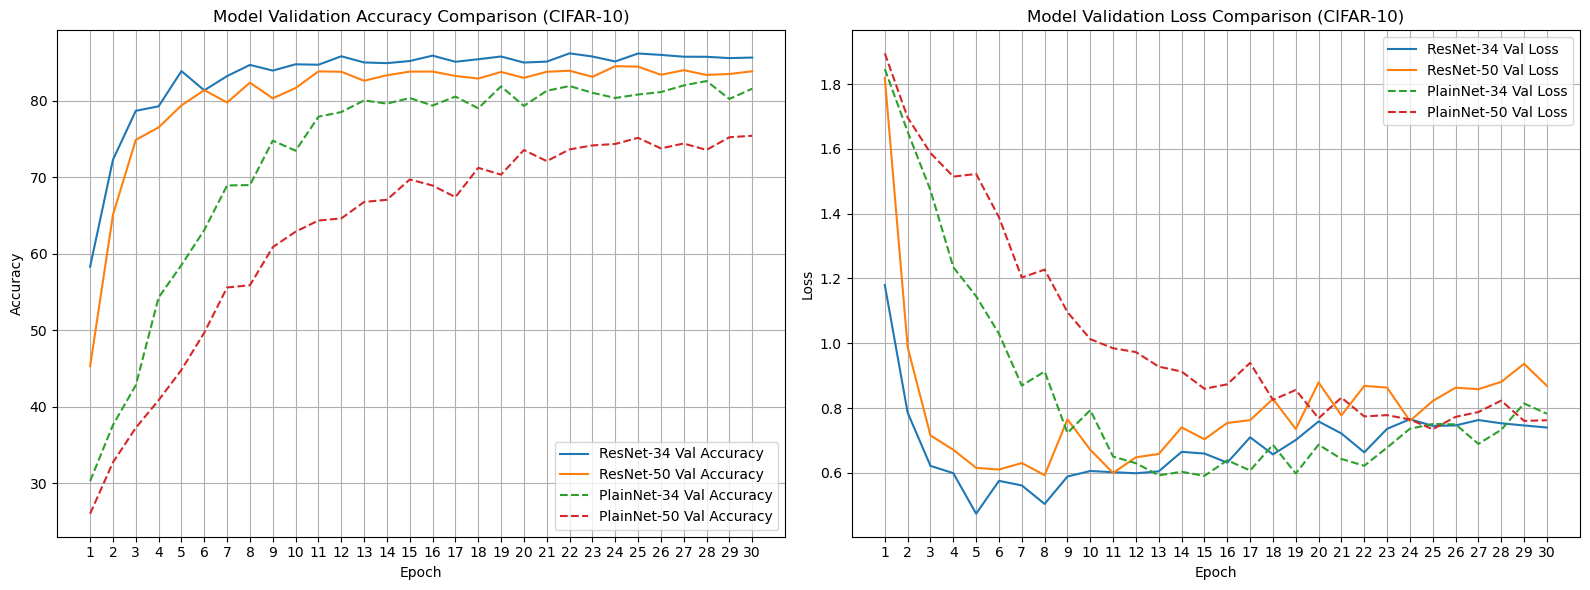

In [35]:
import torch.optim as optim
import time
from tqdm import tqdm, trange

# (Assuming all previous cells with model definitions, data, etc., have been run)
# (Assuming NUM_CLASSES=10 and device are defined)

# These models are assumed to be defined and instantiated from the previous cells
models = {
    "ResNet-34": build_resnet34(num_classes=NUM_CLASSES),
    "ResNet-50": build_resnet50(num_classes=NUM_CLASSES),
    "PlainNet-34": build_plainnet34(num_classes=NUM_CLASSES),
    "PlainNet-50": build_plainnet50(num_classes=NUM_CLASSES)
}

histories = {} 

for name, model in models.items():
    print(f"\n--- Training {name} for {EPOCHS} epochs ---")
    
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    
    # MODIFIED: Added train_accuracy and train_loss keys
    history = {'val_accuracy': [], 'val_loss': [], 'train_accuracy': [], 'train_loss': []}
    
    for epoch in trange(EPOCHS, desc=f"Epoch for {name}"):
        # --- Training Loop ---
        model.train()
        running_loss = 0.0
        
        # MODIFIED: Added variables to track epoch train stats
        epoch_train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        train_bar = tqdm(trainloader, desc=f"Training {name} Batch")
        for i, (inputs, labels) in enumerate(train_bar, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            train_bar.set_postfix({'loss': running_loss / (i+1)})
            
            # MODIFIED: Accumulate total train loss and correct predictions
            epoch_train_loss += loss.item() * inputs.size(0)
            _, predicted_train = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted_train == labels).sum().item()

        # MODIFIED: Calculate and store average train stats for the epoch
        epoch_train_acc = 100 * train_correct / train_total
        epoch_train_loss = epoch_train_loss / train_total
        history['train_accuracy'].append(epoch_train_acc)
        history['train_loss'].append(epoch_train_loss)

        # --- Validation Loop ---
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_acc = 100 * correct / total
        epoch_val_loss = val_loss / len(testloader)
        
        # MODIFIED: Store validation stats
        history['val_accuracy'].append(epoch_val_acc)
        history['val_loss'].append(epoch_val_loss)
        
        # Modified tqdm.write to include train stats
        tqdm.write(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%")

    histories[name] = history
    end_time = time.time()
    print(f"--- {name} training finished in {end_time - start_time:.2f} seconds ---")

    # MODIFIED: Save the model state dictionary
    model_path = f"{name}_cifar10_model.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model {name} saved to {model_path}")

print("\nAll models training complete.")

# --- Plotting section (unchanged from your cell, but now history dict is populated) ---
plt.figure(figsize=(16, 6))
# Create a new epochs_range variable for plotting
epochs_range_plot = np.arange(1, EPOCHS + 1) 

plt.subplot(1, 2, 1)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-'
    plt.plot(epochs_range_plot, history['val_accuracy'], label=f'{name} Val Accuracy', linestyle=linestyle)
plt.title('Model Validation Accuracy Comparison (CIFAR-10)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_range_plot)
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-'
    plt.plot(epochs_range_plot, history['val_loss'], label=f'{name} Val Loss', linestyle=linestyle)
plt.title('Model Validation Loss Comparison (CIFAR-10)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs_range_plot)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('resnet_vs_plainnet_comparison_pytorch_cifar10.png')
# plt.show() # Use savefig instead of show in this environment

학습 결과

Generating plots...
Script finished.


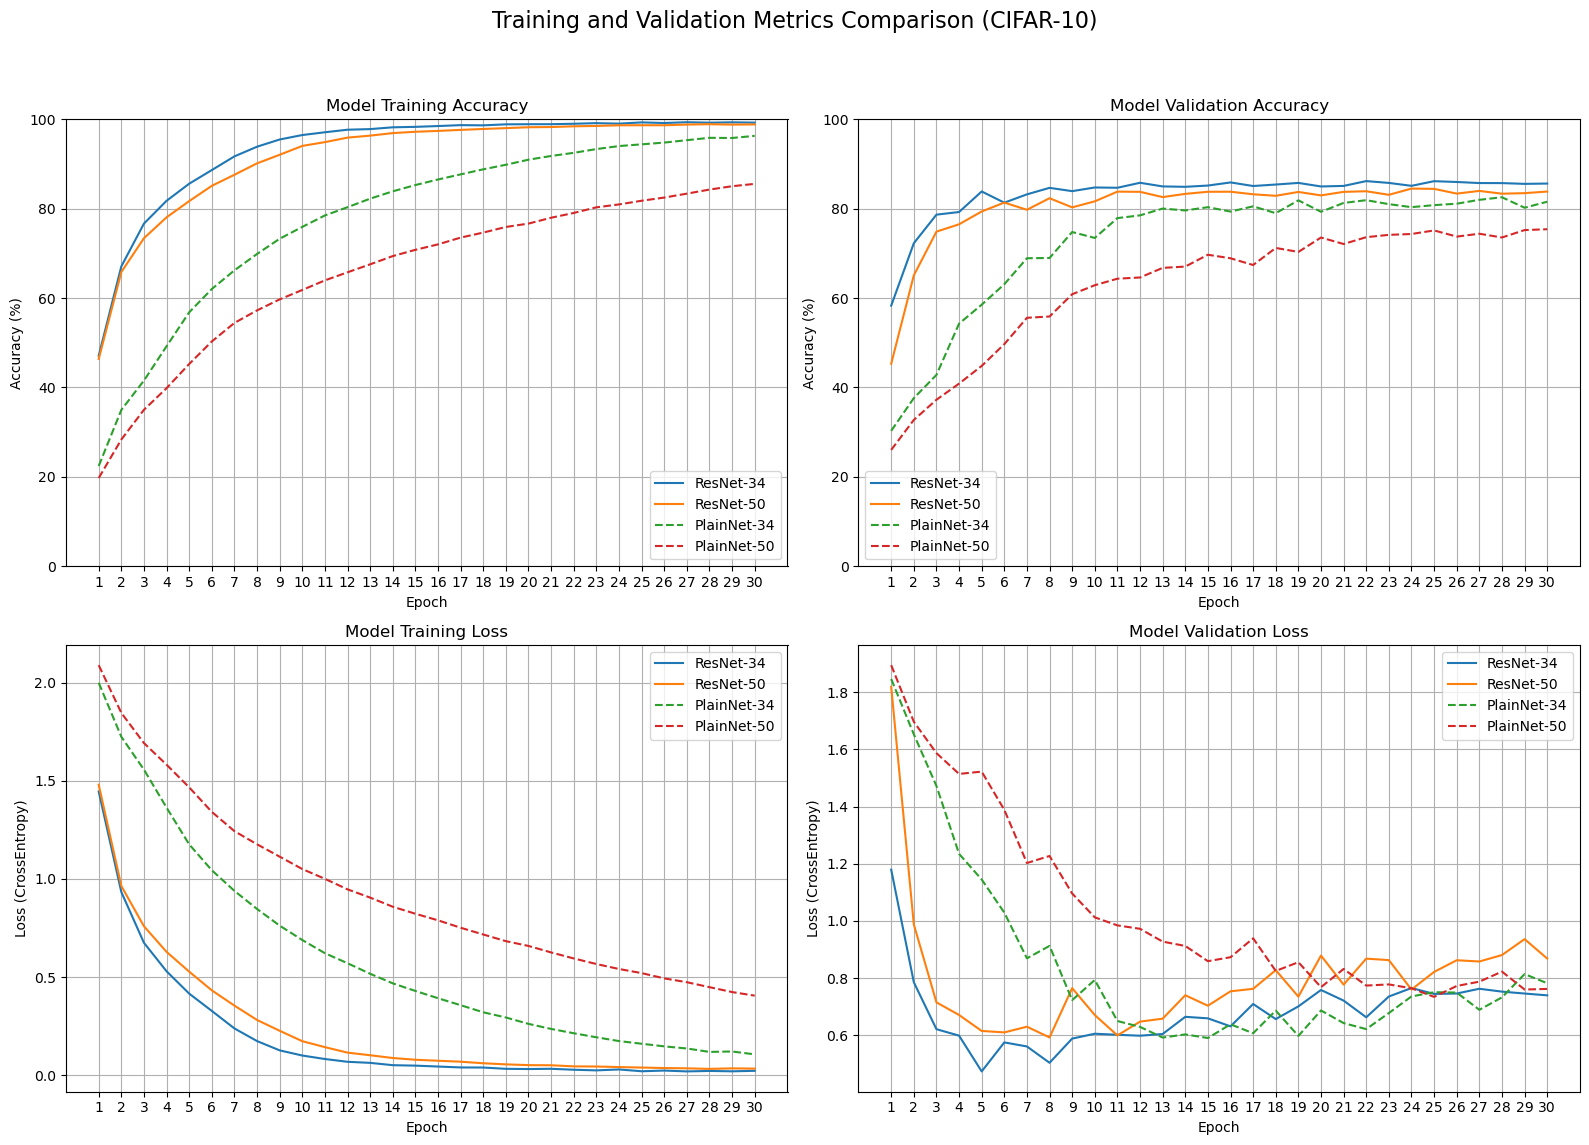

In [36]:
print("Generating plots...")
plt.figure(figsize=(16, 12))
epochs_range = np.arange(1, EPOCHS + 1)

# --- 1. Training Accuracy ---
plt.subplot(2, 2, 1)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-' 
    # MODIFIED: Key changed from 'train_acc' to 'train_accuracy'
    plt.plot(epochs_range, history['train_accuracy'], label=f'{name}', linestyle=linestyle)
plt.title('Model Training Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

# --- 2. Validation Accuracy ---
plt.subplot(2, 2, 2)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-'
    plt.plot(epochs_range, history['val_accuracy'], label=f'{name}', linestyle=linestyle)
plt.title('Model Validation Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)

# --- 3. Training Loss ---
plt.subplot(2, 2, 3)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-'
    # MODIFIED: Key changed from 'train_loss' to 'train_loss'
    plt.plot(epochs_range, history['train_loss'], label=f'{name}', linestyle=linestyle)
plt.title('Model Training Loss')
plt.ylabel('Loss (CrossEntropy)')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

# --- 4. Validation Loss ---
plt.subplot(2, 2, 4)
for name, history in histories.items():
    linestyle = '--' if 'Plain' in name else '-'
    plt.plot(epochs_range, history['val_loss'], label=f'{name}', linestyle=linestyle)
plt.title('Model Validation Loss')
plt.ylabel('Loss (CrossEntropy)')
plt.xlabel('Epoch')
plt.xticks(epochs_range)
plt.legend()
plt.grid(True)

plt.suptitle('Training and Validation Metrics Comparison (CIFAR-10)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('resnet_vs_plainnet_all_metrics_pytorch_cifar10.png')
# plt.show() # Use savefig instead of show in this environment

print("Script finished.")

ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가?

    - 블록 함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다.

구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가?

    - tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다.

Ablation Study 결과가 바른 포맷으로 제출되었는가?

    - ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다.